<a href="https://colab.research.google.com/github/guten-morgen3776/LLM-material-exprolation/blob/main/%E5%8C%96%E5%90%88%E7%89%A9%E6%8E%A2%E7%B4%A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rdkit

In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, DataStructs
from IPython.display import display, Image

In [ ]:
generated_smiles_list = [
    "O=C(Nc1ccc(F)cc1)c1cn(C)n-c1C",
    "CC(C)OC(=O)c1cn(C2CC2)c2ccccc12",
    "CNC(=O)c1cc(c2cnc(N3CCOCC3)s2)cn1",
    "O=C1NC(c2ccccc2)c2c(N1)cnn2C1CC1",
    "Cc1ccc(S(=O)(=O)N2CCC(NC(=O)C)CC2)nc1",
    "Fc1cc(c2[nH]c3nccc(OC)c3n2)ccc1",
    "CC1(C)CN(c2nnc(C(F)(F)F)o2)C(=O)O1",
    "N#Cc1c(N2CCCC2)nc2c(c1)n(C)cn2",
    "c1ccc(C2CC2N2C(=O)c3cncnc3C2=O)cc1",
    "CC(O)CN1CCN(c2nc3cc(Cl)ccc3o2)CC1",
    "O=C(c1cc(F)cn1)N1CCN(C2CC2)CC1",
    "Cc1ccc(S(=O)(=O)N2CC(N(C)C(=O)C)C2)cc1",
    "CNC(=O)C1(c2ccccc2)CCCN1c1ncccn1",
    "c1cn(C2CC(O)C(n3cncn3)C2)c2ccccc12",
    "O=C1N(C)c2c(c(C#N)cn2C2CC2)C(=O)N1C",
    "CC1(C)OC(=O)N(c2ccc(N3CCOCC3)cn2)C1",
    "Fc1cc(c2c(C(F)(F)F)cn(C3CCOC3)n2)ccc1F",
    "O=S(=O)(c1ccsc1)N1CCC(Oc2nccc(C)n2)CC1",
    "CC(C)OC(=O)c1c(C)n(C)c2c1c(=O)n(C1CC1)cn2",
    "N#Cc1cccc(N2C(=O)C3(CCCCC3)C2=O)c1",
]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_pubchem = pd.read_csv('/content/drive/MyDrive/PubChem_compound_cache_05R2RRqTfy9IBX0c_2Q0OxY33lcrBcEpuwzaZaAdyGSgBPQ.csv')

In [ ]:
df_pubchem['SMILES']

,SMILES
0,C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])Cl
1,C(CCl)Cl
2,C(CCl)O
3,CC(C)(CO)C(=O)C(=O)O
4,C1C(C(C(OC1O)CO)O)O
...,...
17927,C[C@@H]1CC=CC=C[C@@H]([C@@H](C[C@@H]([C@@H](C(...
17928,CC(C)(C(OC1=C2C(=C(C=C1)C3=NC=CS3)OC(=N2)N4C[C...
17929,CC1=C(N=CC=C1)C2=CN=C(C=C2)C3=C4C=C(C=NC4=NN3)...
17930,C1CC(CCC1CNC(=O)CN2CCN(CCN(CCN(CC2)CC(=O)[O-])...


In [ ]:
SMILES_COLUMN_NAME = 'SMILES'
known_drugs_smiles = df_pubchem[SMILES_COLUMN_NAME].dropna().tolist()

In [ ]:
known_mols = [Chem.MolFromSmiles(s) for s in known_drugs_smiles]
known_mols_valid = [m for m in known_mols if m is not None]
known_fps = [Chem.RDKFingerprint(m) for m in known_mols_valid]

[02:18:51] WARNING: not removing hydrogen atom without neighbors
[02:18:51] WARNING: not removing hydrogen atom without neighbors
[02:18:52] WARNING: not removing hydrogen atom without neighbors
[02:18:52] WARNING: not removing hydrogen atom without neighbors
[02:18:53] WARNING: not removing hydrogen atom without neighbors
[02:18:53] WARNING: not removing hydrogen atom without neighbors
[02:18:53] WARNING: not removing hydrogen atom without neighbors
[02:18:53] WARNING: not removing hydrogen atom without neighbors
[02:18:53] WARNING: not removing hydrogen atom without neighbors
[02:18:53] WARNING: not removing hydrogen atom without neighbors
[02:18:53] WARNING: not removing hydrogen atom without neighbors
[02:18:53] WARNING: not removing hydrogen atom without neighbors
[02:18:53] WARNING: not removing hydrogen atom without neighbors
[02:18:53] WARNING: not removing hydrogen atom without neighbors
[02:18:53] WARNING: not removing hydrogen atom without neighbors
[02:18:53] WARNING: not r

In [ ]:
print(len(known_fps),
      len(known_mols),
      len(known_mols_valid))


17932 17932 17932


In [ ]:
eval_result = []
THRESHOLD = 0.85

for i, smiles_str in enumerate(generated_smiles_list):
  mol = Chem.MolFromSmiles(smiles_str)

  if mol is None:
    eval_result.append({
        'ID': i+1, 'SMILES': smiles_str, 'evalation': 'False(SMILES invalid)',
        'MW': 'N/A', 'LogP': 'N/A', 'HBD': 'N/A', 'HBA': 'N/A', "Max Tanimoto": "N/A", 'Most Similar SMILES': 'N/A'
    })
    continue

  #制約評価(リピンスキーの法則)
  mw = Descriptors.MolWt(mol)
  logp = Descriptors.MolLogP(mol)
  h_donors = Descriptors.NumHDonors(mol)
  h_acceptors = Descriptors.NumHAcceptors(mol)
  lipinski_ok = (mw <= 500) and (logp <= 5) and (h_donors <= 5) and (h_acceptors <= 10)

  if not lipinski_ok:
    eval_result.append({
        'ID': i+1, 'SMILES': smiles_str, 'evalation': 'False(仕様違反)',
        'MW': f'{mw: .2f}', 'LogP': f'{logp: .2f}', 'HBD': h_donors, 'HBA': h_acceptors, "Max Tanimoto": "N/A", 'Most Similar SMILES': 'N/A'
    })
    continue

  #新規性評価
  gen_fp = Chem.RDKFingerprint(mol)
  similarity = DataStructs.BulkTanimotoSimilarity(gen_fp, known_fps)
  max_similarity = np.max(similarity)

  if similarity:
    max_index = np.argmax(similarity)
    most_similar_smiles = similarity[max_index]
    most_similar_smiles_str = known_drugs_smiles[max_index]
  else:
    most_similar_smiles = 0
    most_similar_smiles_str = 'N/A'


  if max_similarity >= THRESHOLD:
    eval_result.append({
        'ID': i+1, 'SMILES': smiles_str, 'evalation': 'False(新規性なし))',
        'MW': f'{mw: .2f}', 'LogP': f'{logp: .2f}', 'HBD': h_donors, 'HBA': h_acceptors,
        "Max Tanimoto": f"{max_similarity:.2f}", 'Most Similar SMILES': most_similar_smiles_str
    })
  else:
    eval_result.append({
        'ID': i+1, 'SMILES': smiles_str, 'evalation': 'Success',
        'MW': f'{mw: .2f}', 'LogP': f'{logp: .2f}', 'HBD': h_donors, 'HBA': h_acceptors,
        "Max Tanimoto": f"{max_similarity:.2f}", 'Most Similar SMILES': most_similar_smiles_str
    })


[02:19:59] Can't kekulize mol.  Unkekulized atoms: 10 11 14 15
[02:19:59] Can't kekulize mol.  Unkekulized atoms: 4 5 6 18 19
[02:19:59] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 7


In [ ]:
df_results = pd.DataFrame(eval_result)
df_results

,ID,SMILES,evalation,MW,LogP,HBD,HBA,Max Tanimoto,Most Similar SMILES
0,1,O=C(Nc1ccc(F)cc1)c1cn(C)n-c1C,False(SMILES invalid),N/A,N/A,N/A,N/A,N/A,N/A
1,2,CC(C)OC(=O)c1cn(C2CC2)c2ccccc12,Success,243.31,3.54,0,3,0.70,C1=CC=C2C(=C1)C=CC=C2OC(=O)C3=CN(C4=CC=CC=C43)...
2,3,CNC(=O)c1cc(c2cnc(N3CCOCC3)s2)cn1,False(SMILES invalid),N/A,N/A,N/A,N/A,N/A,N/A
3,4,O=C1NC(c2ccccc2)c2c(N1)cnn2C1CC1,Success,254.29,2.44,2,3,0.54,CC[C@@]1(C[C@H]2C[C@@](C3=C(CCN(C2)C1)C4=CC=CC...
4,5,Cc1ccc(S(=O)(=O)N2CCC(NC(=O)C)CC2)nc1,Success,297.38,0.68,1,4,0.48,C[C@@H]1CC[C@@H](C(=O)CN1S(=O)(=O)C2=CC=CC=N2)...
5,6,Fc1cc(c2[nH]c3nccc(OC)c3n2)ccc1,Success,243.24,2.77,1,3,0.42,CN1C2=C(N=CC(=C2)C3=CC=CC=C3)N=C1N
6,7,CC1(C)CN(c2nnc(C(F)(F)F)o2)C(=O)O1,Success,251.16,1.82,0,5,0.39,C[C@@]1(CCC[C@]2(C1)CN(C(=O)O2)C3=NC=C(N=C3)C(...
7,8,N#Cc1c(N2CCCC2)nc2c(c1)n(C)cn2,Success,227.27,1.44,0,5,0.46,C[C@@H](C1=NC=C(C=N1)F)NC2=NC3=C(C=C2)N=CN3C4=...
8,9,c1ccc(C2CC2N2C(=O)c3cncnc3C2=O)cc1,Success,265.27,1.63,0,4,0.52,CC1=C(N=CN1)CN2CCC3=C(C2=O)C4=CC=CC=C4N3C
9,10,CC(O)CN1CCN(c2nc3cc(Cl)ccc3o2)CC1,Success,295.77,1.98,1,5,0.72,CC1=CC(=CC2=C1OC(=N2)N3CCCNCC3)Cl


In [ ]:
invalid_smiles = df_results[df_results['evalation'] == 'False(SMILES invalid)']['SMILES'].tolist()
invalid_mols = [Chem.MolFromSmiles(s) for s in invalid_smiles]

[02:23:10] Can't kekulize mol.  Unkekulized atoms: 10 11 14 15
[02:23:10] Can't kekulize mol.  Unkekulized atoms: 4 5 6 18 19
[02:23:10] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 7


In [ ]:
typeA_count = df_results[df_results['evalation'] == 'False(SMILES invalid)'].shape[0]
typeB_count = df_results[df_results['evalation'] == 'False(仕様違反)'].shape[0]
typeC_count = df_results[df_results['evalation'] == 'False(新規性なし))'].shape[0]
typeD_count = df_results[df_results['evalation'] == 'Success'].shape[0]
print(f'False(SMILES invalid): {typeA_count}')
print(f'False(仕様違反): {typeB_count}')
print(f'False(新規性なし): {typeC_count}')
print(f'Success: {typeD_count}')

False(SMILES invalid): 3
False(仕様違反): 0
False(新規性なし): 0
Success: 17


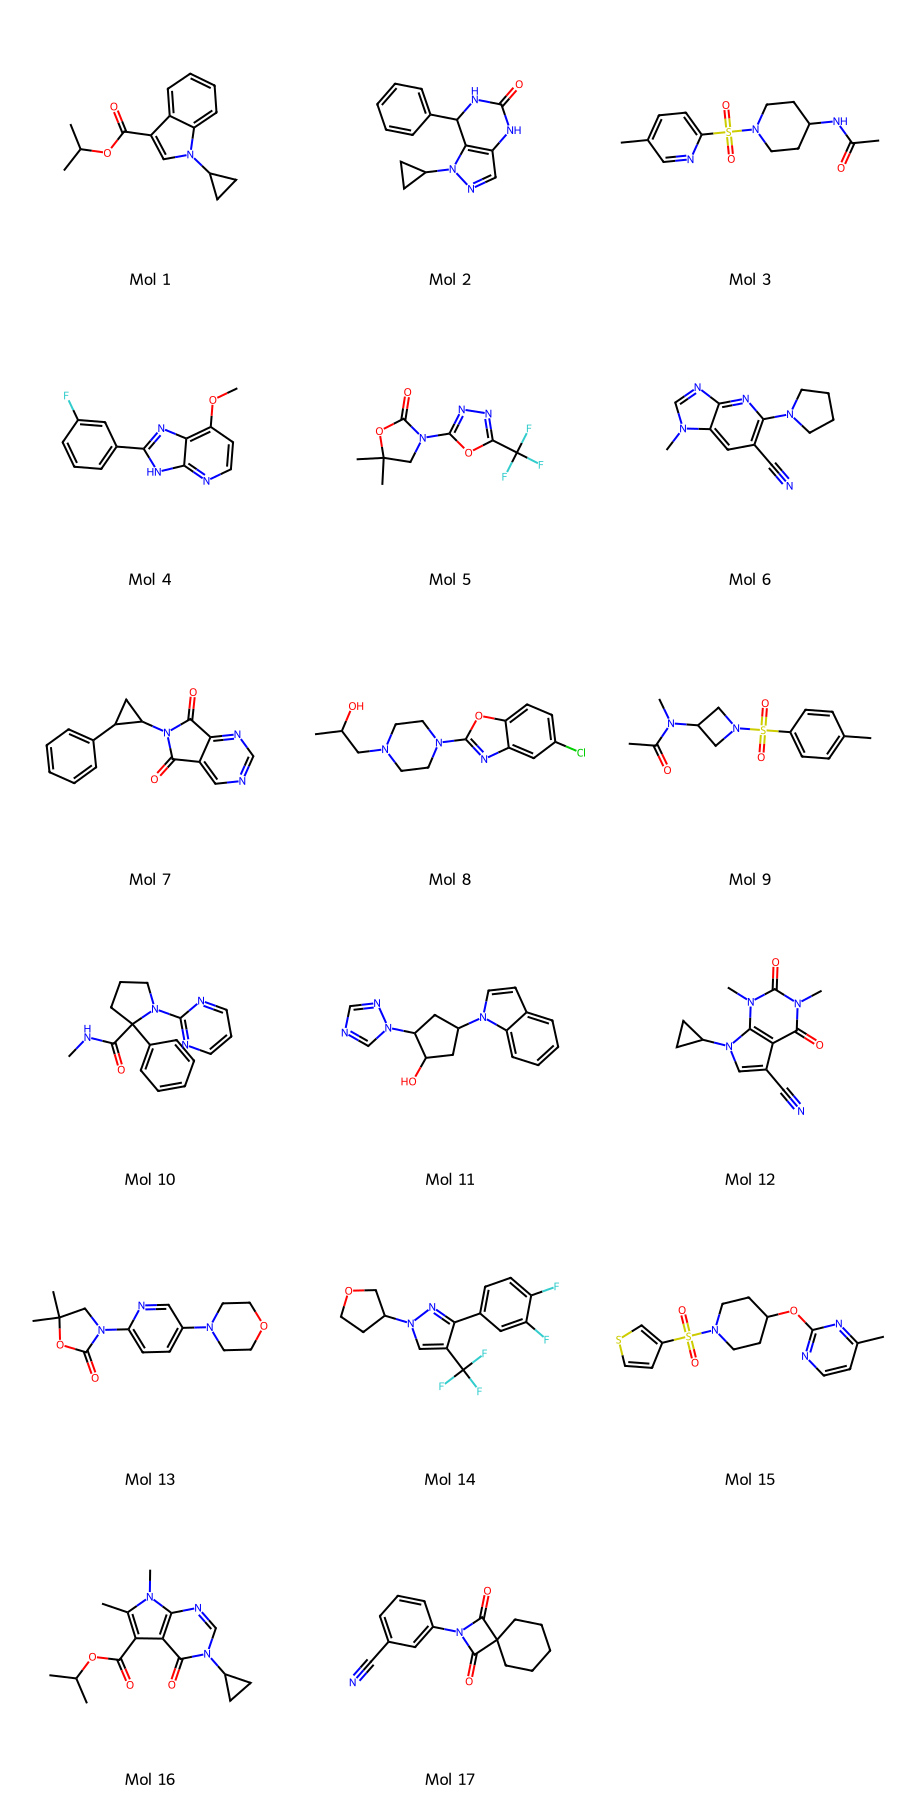

In [ ]:
success_smiles = df_results[df_results['evalation'] == 'Success']['SMILES'].tolist()
success_mols = [Chem.MolFromSmiles(s) for s in success_smiles if s is not None]
img_success_grid = Draw.MolsToGridImage(success_mols, molsPerRow=3, subImgSize=(300, 300), legends=[f'Mol {i+1}' for i in range(len(success_mols))])
display(img_success_grid)
